In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from math import pi
import random
import numpy as np
from math import cos, sin, tan, atan

# Means of Modeling Manipulators

To start, the classes "Manipulator" and "Link" were created that allows the representation of the specifications of manipulators. These classes will be used later on to generate the data required for the manipulators we will train our models to compute the inverse kinematics for. For an instance of this class to be instantiated, the Denavit-Hartenberg (DH) parameters of the manipulator's links will have to be provided. This allows for the forward kinemtics to be computed in order to find the position of the end effector, given the link's angles.

In [3]:
class Link():
    def __init__(self,theta_offset,d,alpha,a):
        self.theta_offset = theta_offset
        self.d = d
        self.alpha = alpha
        self.a = a
    def get_transformation(self, theta):
        theta = theta+self.theta_offset
        transformation_matrix = np.array([
            [cos(theta), -sin(theta) * cos(self.alpha), sin(theta) * sin(self.alpha), self.a * cos(theta)],
            [sin(theta), cos(theta) * cos(self.alpha), -cos(theta) * sin(self.alpha), self.a * sin(theta)],
            [0, sin(self.alpha), cos(self.alpha), self.d],
            [0, 0, 0, 1]
        ])
        return transformation_matrix

class Manipulator:
    def __init__(self, links=None, q=None):
        self.links = links if links else []
        self.q = q if q else []

    def add_link(self, link):
        self.links.append(link)

    def forward_kinematics(self, joint_angles):
        transformation_matrix = np.identity(4)
        pos = []
        for i in range(len(self.links)):
            transformation_matrix = np.dot(transformation_matrix, self.links[i].get_transformation(joint_angles[i]))
            pos.append([transformation_matrix[0][3],transformation_matrix[1][3]])
        return transformation_matrix

# Two-Joints Manipulator Continous Path

In the second iteration, the aim is to design a neural network capable of determining the **joint angles necessary** for the manipulator to reach a desired end-effector position. This neural network will take as inputs both the desired **end-effector position** as well as the **current joint angles** of the manipulator. The output will be the set of joint angles required to achieve the specified end-effector position.

**Input:**
- eef_x: x component of the end-effector's position (float)
- eef_y: y component of the end-effector's position (float)
- q1_current: current theta_1 angle (float)
- q2_current: current theta_2 angle (float)

**Output:**
- q1_next: next theta_1 angle required to achieve (eef_x,eef_y) position (float)
- q2_next: next theta_2 angle required to achieve (eef_x,eef_y) position (float)

**Initiating a 2-Joints Manipulator**

The class "Manipulator" created was then used to create an instant of a 2 joints model. A sketch of the first manipulator considered can be seen below along with it's DH parameters required to set it up.

<img height="300px"  style="padding:20px" src="https://github.com/omarrayyann/IK-NN/blob/master/Images/two_joints_manip.jpg?raw=1">
<img height="300px"  style="padding:20px" src="https://github.com/omarrayyann/IK-NN/blob/master/Images/dh_table.jpg?raw=1">



In [4]:
link1 = Link(theta_offset=0, d=0, alpha=0, a=5)
link2 = Link(theta_offset=0, d=0, alpha=0, a=5)

manip = Manipulator()
manip.add_link(link1)
manip.add_link(link2)

In [5]:
end_effector_positions = manip.forward_kinematics([pi/4,pi/2])
x = end_effector_positions[0][3]
y = end_effector_positions[1][3]
print(x)
print(y)

4.440892098500626e-16
7.0710678118654755


**Data Generation Specifications (exporting data):**

- Range of q1_next: from 0 to 2pi
- Range of q2_next: from 0 to 2pi
- Step Size for both q1_next and q2_next: 0.01

- q1_current and q2_current will be set to 20 random angles +/- a maximum of 0.005 from q1_next and q2_next respectively

(Note: Can skip this block if file "two_joints_with_nearby_data.txt" already in directory)

In [9]:
q1_next_from = 0
q1_next_to = 2*pi
q1_next_step_size = 0.3

q2_next_from = 0
q2_next_to = 2*pi
q2_next_step_size = 0.3

total_iterations = ((q1_next_to - q1_next_from) / q1_next_step_size + 1) * ((q2_next_to - q2_next_from) / q2_next_step_size + 1)
progress_interval = total_iterations // 10

with open('two_joints_with_nearby_data.txt', 'w') as file:
    q1_next = q1_next_from
    iterations = 0
    while q1_next <= q1_next_to:
        q2_next = q2_next_from
        while q2_next <= q2_next_to:
            end_effector_positions = manip.forward_kinematics([q1_next,q2_next])
            x = end_effector_positions[0][3]
            y = end_effector_positions[1][3]
            for i in range(20):
                ran = random.uniform(-0.1, 0.1)
                q1_current = q1_next + ran
                ran = random.uniform(-0.1, 0.1)
                q2_current = q2_next + ran
                file.write(f"{x} {y} {q1_current} {q2_current} {q1_next} {q2_next} \n")
            iterations += 1
            if iterations % progress_interval == 0:
                progress_percent = (iterations / total_iterations) * 100
                print(f"Progress: {progress_percent:.2f}%")
            q2_next = q2_next + q2_next_step_size
        q1_next = q1_next + q2_next_step_size
print(f"Progress: 100.00%")

Progress: 9.97%
Progress: 19.94%
Progress: 29.90%
Progress: 39.87%
Progress: 49.84%
Progress: 59.81%
Progress: 69.78%
Progress: 79.74%
Progress: 89.71%
Progress: 100.00%


**Getting Data (importing data):**

Storing the inputs (eef_x,eef_y,q1_current,q2_current) and outputs (q1_next,q2_next) in the required format

In [10]:
eef_x = []
eef_y = []
q1_current = []
q2_current = []

q1_next = []
q2_next = []

with open('two_joints_with_nearby_data.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        eef_x.append(float(data[0]))
        eef_y.append(float(data[1]))
        q1_current.append(float(data[2]))
        q2_current.append(float(data[3]))
        q1_next.append(float(data[4]))
        q2_next.append(float(data[5]))

eef_x = np.array(eef_x)
eef_y = np.array(eef_y)
q1_current = np.array(q1_current)
q2_current = np.array(q2_current)

q1_next = np.array(q1_next)
q2_next = np.array(q2_next)

print("eef_x Shape: ", eef_x.shape)
print("eef_y Shape: ", eef_y.shape)
print("q1_current Shape: ", q1_current.shape)
print("q2_current Shape: ", q2_current.shape)

print("q1_next Shape: ", q1_next.shape)
print("q2_next Shape: ", q2_next.shape)

eef_x Shape:  (8820,)
eef_y Shape:  (8820,)
q1_current Shape:  (8820,)
q2_current Shape:  (8820,)
q1_next Shape:  (8820,)
q2_next Shape:  (8820,)


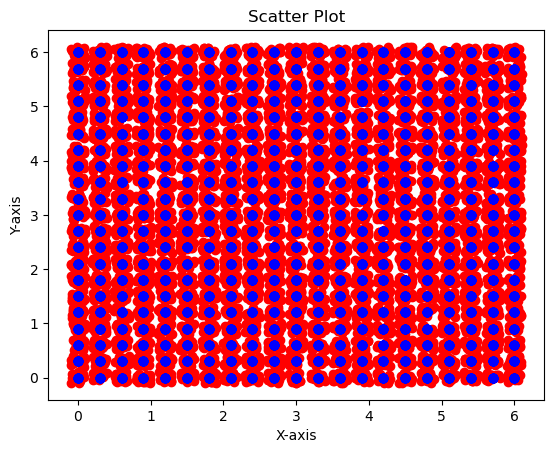

In [11]:
# Create a scatter plot
plt.scatter(q1_current, q2_current, color="r")
plt.scatter(q1_next, q2_next, color="b")

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')

# Show the plot
plt.show()

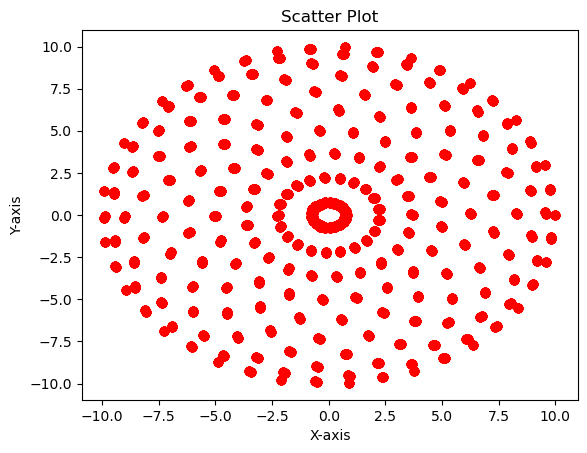

In [12]:
# Create a scatter plot
plt.scatter(eef_x, eef_y, color="r")

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')

# Show the plot
plt.show()

**0. Necessary Setup**

In [13]:
# Using cuda GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class PosesDataset(Dataset):
    def __init__(self, eef_x, eef_y, q1_current, q2_current, q1_next, q2_next):
        self.eef_x = torch.tensor(eef_x, dtype=torch.float32)
        self.eef_y = torch.tensor(eef_y, dtype=torch.float32)
        self.q1_current = torch.tensor(q1_current, dtype=torch.float32)
        self.q2_current = torch.tensor(q2_current, dtype=torch.float32)
        self.q1_next = torch.tensor(q1_next, dtype=torch.float32)
        self.q2_next = torch.tensor(q2_next, dtype=torch.float32)

    def __len__(self):
        return len(self.eef_x)

    def __getitem__(self, idx):
        return (
            self.eef_x[idx],
            self.eef_y[idx],
            self.q1_current[idx],
            self.q2_current[idx],
            self.q1_next[idx],
            self.q2_next[idx]
        )

In [15]:
# Initialize dataset
dataset = PosesDataset(eef_x, eef_y, q1_current, q2_current, q1_next, q2_next)

# Define train/validation split (if needed)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Initialize data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# print(test_size)
# print(train_size)

In [16]:
class IKModel(nn.Module):
    def __init__(self):
        super(IKModel, self).__init__()
        # Define your model architecture
        # Example:
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Sigmoid(),
            nn.Linear(8, 2)  # Output layer for q1_next, q2_next
        )

    def forward(self, x):
 

        # Concatenate the original features with cosine and sine terms
        # x = torch.cat((x, cos_q1, sin_q1, cos_q2, sin_q2), dim=1)  # Concatenate along the feature dimension
        # Forward pass through the model
        output = self.fc(x)
        return output


In [17]:
model = IKModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Loss = nn.MSELoss()
print(model)

IKModel(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [29]:
num_of_epochs = 200
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_of_epochs):
  train_loss = 0.0
  test_loss = 0.0
  train_loss_size = 0
  test_loss_size = 0
  model.train()
  for i, batch in enumerate(train_loader):
    eef_x, eef_y, q1_current, q2_current, q1_next, q2_next = batch
    eef_x, eef_y, q1_current, q2_current, q1_next, q2_next = (
            eef_x.to(device).float(),
            eef_y.to(device).float(),
            q1_current.to(device).float(),
            q2_current.to(device).float(),
            q1_next.to(device).float(),
            q2_next.to(device).float(),
        )

    x = torch.cat((eef_x.unsqueeze(1), eef_y.unsqueeze(1), q1_current.unsqueeze(1), q2_current.unsqueeze(1)), dim=1).to(device)

    # Forward Pass
    output = model(x)
    print(x[0])
    print(output[0])
    break
    # Finding Loss
    combined_q = torch.cat((q1_next.unsqueeze(1), q2_next.unsqueeze(1)), dim=1)
    fit = Loss(output, combined_q)
    optimizer.zero_grad()
    fit.backward()
    # Optimizing Loss
    optimizer.step()
    train_loss_size += len(eef_x)
    train_loss += fit.item()
  model.eval()
  for i, batch in enumerate(test_loader):
    with torch.no_grad():
      eef_x, eef_y, q1_current, q2_current, q1_next, q2_next = batch
      eef_x, eef_y, q1_current, q2_current, q1_next, q2_next = (
              eef_x.to(device).float(),
              eef_y.to(device).float(),
              q1_current.to(device).float(),
              q2_current.to(device).float(),
              q1_next.to(device).float(),
              q2_next.to(device).float(),
          )

      x = torch.cat((eef_x.unsqueeze(1), eef_y.unsqueeze(1), q1_current.unsqueeze(1), q2_current.unsqueeze(1)), dim=1).to(device)
      # Forward Pass
      output = model(x)
      # Finding Loss
      combined_q = torch.cat((q1_next.unsqueeze(1), q2_next.unsqueeze(1)), dim=1)
      fit = Loss(output, combined_q)
      # Optimizing Loss
      test_loss_size += len(eef_x)
      test_loss += fit.item()
  train_loss = train_loss/train_loss_size
  test_loss = test_loss/test_loss_size
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print(f"Epoch: {epoch}, Training Loss: {train_loss:.10f}, Testing Loss: {test_loss:.10f}")
  torch.save(model.state_dict(),'model.pt')
  dummy_input = torch.randn(1, 4).to(device)  # Assuming a batch size of 1 and 4 input features

  # Export the model to ONNX format
  torch.onnx.export(model, dummy_input, "IKModel.onnx", verbose=False)


tensor([ 8.1735, -3.8638,  0.0984,  5.3121])
tensor([0.0507, 5.3055], grad_fn=<SelectBackward0>)


ZeroDivisionError: float division by zero

In [19]:
torch.save(model.state_dict(),'model.pt')

In [20]:
print(train_loss_history)
print(test_loss_history)

[0.1284926850644369, 0.08020924727797779, 0.06248780780909013, 0.055721346787314295, 0.05321449470492988, 0.05243970325339138, 0.052026238131955636, 0.05193269266292892, 0.052046846370307764, 0.05196663463602261, 0.051965063154832576, 0.05204993570878122, 0.05193110378015609, 0.051989317379570875, 0.05168354795092628, 0.045203765672621, 0.03542290546861636, 0.030906411305982238, 0.026625815635365424, 0.021533686566312295, 0.01588506611431537, 0.011204940526663851, 0.007786670175978656, 0.005463832902749515, 0.003894363838309198, 0.002902398371642409, 0.0021720669663124748, 0.0016656881401551859, 0.0013211618220885528, 0.0010587399875082058, 0.0008647026564892119, 0.0007138486445803288, 0.0006056606258495865, 0.0005157818950980885, 0.00044942503811394515, 0.000386646606966266, 0.000340539064124235, 0.00030455642573581904, 0.0002766814631412055, 0.00024143714920243844, 0.00022233053235402606, 0.00020202835582253733, 0.00018601127675271968, 0.0001713174079212755, 0.00015854175991717676, 0

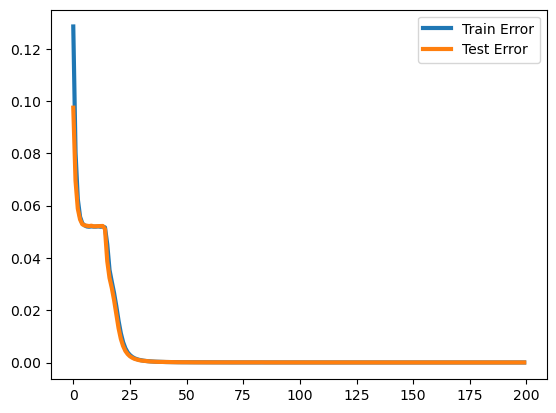

In [21]:
fig = plt.figure()
plt.plot(range(len(train_loss_history)),train_loss_history,"-",linewidth=3,label="Train Error")
plt.plot(range(len(test_loss_history)),test_loss_history,"-",linewidth=3,label="Test Error")
plt.legend()
plt.show()

In [22]:
with torch.no_grad():  # Ensure gradients are not calculated
    output = model(new_input)

NameError: name 'new_input' is not defined

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [34]:
import torch

# 2.946297338493151 -4.360614348632136 0.038424728324865494 4.249459785484152 0.04 4.249999999999954

# Input values
eef_x = 8.173500061035156
eef_y = -3.863800048828125
q1_current = 0.09839999675750732
q2_current = 5.312099933624268


# Convert the inputs into tensors and add a batch dimension
x = torch.tensor([8.1735, -3.8638, 0.0984,  5.3121]).to(device)

print(x)
# Pass the input through the model
model.eval()
with torch.no_grad():
    output = model(x)

print(output)

tensor([ 8.1735, -3.8638,  0.0984,  5.3121])
tensor([0.0507, 5.3055])


In [ ]:
pip install onnx


In [32]:
dummy_input = torch.randn(1, 4).to(device)  # Assuming a batch size of 1 and 4 input features

# Export the model to ONNX format
torch.onnx.export(model, dummy_input, "IKModelll.onnx", verbose=True)

Exported graph: graph(%onnx::Gemm_0 : Float(1, 4, strides=[4, 1], requires_grad=0, device=cpu),
      %fc.0.weight : Float(128, 4, strides=[4, 1], requires_grad=1, device=cpu),
      %fc.0.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %fc.2.weight : Float(64, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %fc.2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %fc.4.weight : Float(32, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %fc.4.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %fc.6.weight : Float(16, 32, strides=[32, 1], requires_grad=1, device=cpu),
      %fc.6.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %fc.8.weight : Float(8, 16, strides=[16, 1], requires_grad=1, device=cpu),
      %fc.8.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %fc.10.weight : Float(2, 8, strides=[8, 1], requires_grad=1, device=cpu),
      %fc.10.bias : Float(2, strides=[1], requires_gra